In [2]:
!pip -q install hurst
!pip -q install copulas
!pip -q install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 821.5 kB/s eta 0:00:00


In [3]:
%matplotlib inline
import pandas as pd
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from statsmodels.tsa.vector_ar.vecm import *
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import functools as ft
from statsmodels.tsa.vector_ar import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.cluster import OPTICS
from hurst import compute_Hc
import itertools
import scipy.stats as stats
import seaborn as sns
import matplotlib.dates as mdates
from copulas.bivariate import Clayton, Gumbel, Frank
from copulas.multivariate import VineCopula

In [4]:
def plot_dataframe(df, title=''):
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(pd.to_datetime(df.index), df)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    plt.legend(df.columns)
    plt.grid(True)
    if title != '':
        plt.title(title)
    plt.show()

In [5]:
general_drug_manufacturers = pd.read_csv('processed_datasets/general_drug_manufacturers.csv')
healthcare_plans = pd.read_csv('processed_datasets/healthcare_plans.csv')
special_drug_manufacturers = pd.read_csv('processed_datasets/special_drug_manufacturers.csv')
provided_manufacturing = pd.read_csv('processed_datasets/provided_manufacturing.csv')
provided_multiple = pd.read_csv('processed_datasets/provided_multiple.csv')
provided_technology = pd.read_csv('processed_datasets/provided_technology.csv')
provided_trade_services = pd.read_csv('processed_datasets/provided_trade_services.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'processed_datasets/general_drug_manufacturers.csv'

In [ ]:
food_df = [provided_manufacturing, provided_multiple, provided_technology, provided_trade_services]
healthcare_df = [general_drug_manufacturers, healthcare_plans, special_drug_manufacturers]
food_tickers = []
healthcare_tickers = []

for df in food_df:
    df['Date-Time'] = pd.to_datetime(df['Date-Time'])
    df.set_index('Date-Time', inplace=True)
    df.index.names = ['date']
    for col in df.columns:
        if col != 'date':
            food_tickers.append(col)

for df in healthcare_df:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.index.names = ['date']
    for col in df.columns:
        if col != 'date':
            healthcare_tickers.append(col)

print(food_tickers)
print(healthcare_tickers)

['ADM', 'CAG', 'COKE', 'GIS', 'HRL', 'HSY', 'PEP', 'PPC', 'TSN', 'VMI', 'DIA', 'ONEQ', 'SPY', 'VOO', 'AGCO', 'ALG', 'CAT', 'CNHI', 'DE', 'SAP', 'CMG', 'DPZ', 'DRI', 'MCD', 'QSR', 'SBUX', 'TSCO', 'WEN', 'YUM']
['ABBV', 'AMGN', 'JNJ', 'LLY', 'PFE', 'CI', 'CNC', 'CVS', 'ELV', 'HUM', 'MOH', 'UNH', 'ALKS', 'CTLT', 'ITCI', 'LNTH', 'NBIX', 'PRGO', 'VTRS', 'ZTS']


In [ ]:
provided_manufacturing

,ADM,CAG,COKE,GIS,HRL,HSY,PEP,PPC,TSN,VMI
date,,,,,,,,,,
1999-11-01,11.90,25.81,52.00,85.88,43.13,52.13,33.56,8.56,15.75,17.34
1999-11-02,12.15,25.88,52.00,84.25,42.81,52.63,33.69,8.32,15.88,17.25
1999-11-03,11.89,25.19,52.00,84.63,43.00,51.25,34.25,8.00,16.25,17.00
1999-11-04,11.70,24.31,51.00,83.31,41.88,50.25,33.00,8.04,16.38,17.12
1999-11-05,11.64,24.25,50.69,82.69,43.56,50.25,33.81,8.08,16.69,17.38
...,...,...,...,...,...,...,...,...,...,...
2024-02-13,52.47,27.29,847.84,62.93,28.72,389.68,168.88,28.01,51.61,230.99
2024-02-14,53.27,26.73,848.40,62.37,28.80,382.50,167.52,28.08,51.98,233.61
2024-02-15,54.31,27.17,864.59,63.29,29.11,385.16,167.86,28.59,52.57,230.84


In [ ]:
general_drug_manufacturers

,ABBV,AMGN,JNJ,LLY,PFE
date,,,,,
2000-01-03,NaN,44.925053,24.500574,32.953960,12.687956
2000-01-04,NaN,41.489876,23.603605,31.917288,12.215269
2000-01-05,NaN,42.917488,23.852762,32.325680,12.414297
2000-01-06,NaN,43.631290,24.600231,33.268112,12.862110
2000-01-07,NaN,48.538700,25.646704,35.718460,13.732857
...,...,...,...,...,...
2024-02-23,174.836105,287.140564,160.542267,768.230530,26.966993
2024-02-26,175.542953,284.350403,159.500687,770.606506,26.403563
2024-02-27,175.719666,276.525970,159.689163,763.698303,26.121847


## Pairs Selection
1. PCA for dimensionality reduction
2. OPTICS clustering
3. ARODs (Absolute Rules of Disqualification) --> Johansen's Cointegration Test, Hurst Exponent of Spreads, Half Life of Spreads, Number of Crossings with Mean for Spreads

Number of components: 2


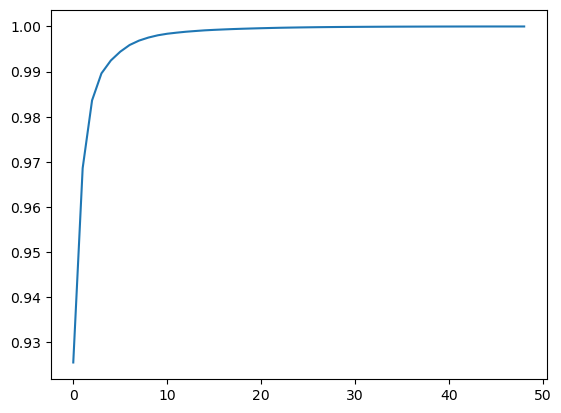

In [ ]:
# PCA dimensionality reduction

data = pd.concat([general_drug_manufacturers, healthcare_plans, special_drug_manufacturers, provided_manufacturing, provided_multiple, provided_technology, provided_trade_services], axis=1)
data = data.dropna().T
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA()
data_pca = pca.fit_transform(data_scaled)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_variance)
n_components = np.argmax(explained_variance >= 0.95) + 1

data_pca_reduced = data_pca[:, :n_components]
print(f'Number of components: {n_components}')

In [ ]:
# OPTICS clustering
optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
optics.fit(data_pca_reduced)

data['cluster'] = optics.labels_

def get_pairs_from_cluster(cluster_data):
    all_pairs = list(itertools.combinations(cluster_data.index, 2))
    filtered_pairs = [(a, b) for a, b in all_pairs if (a in food_tickers and b in healthcare_tickers) or (a in healthcare_tickers and b in food_tickers)]
    return filtered_pairs

pairs = []

for cluster_label, cluster_data in data.groupby('cluster'):
    if cluster_label != -1:
        cluster_pairs = get_pairs_from_cluster(cluster_data)
        pairs.extend(cluster_pairs)

print(pairs)
print(f'Number of Pairs: {len(pairs)}')

[('ABBV', 'GIS'), ('ABBV', 'TSN'), ('ABBV', 'AGCO'), ('ABBV', 'SBUX'), ('CVS', 'GIS'), ('CVS', 'TSN'), ('CVS', 'AGCO'), ('CVS', 'SBUX'), ('NBIX', 'GIS'), ('NBIX', 'TSN'), ('NBIX', 'AGCO'), ('NBIX', 'SBUX'), ('PRGO', 'GIS'), ('PRGO', 'TSN'), ('PRGO', 'AGCO'), ('PRGO', 'SBUX'), ('LNTH', 'PPC'), ('LNTH', 'CNHI'), ('LNTH', 'WEN'), ('JNJ', 'PEP'), ('JNJ', 'SAP'), ('ELV', 'COKE'), ('ELV', 'HSY'), ('ELV', 'DIA'), ('ELV', 'ONEQ'), ('ELV', 'SPY'), ('ELV', 'CAT'), ('ELV', 'DE'), ('ELV', 'CMG'), ('ELV', 'DPZ'), ('HUM', 'COKE'), ('HUM', 'HSY'), ('HUM', 'DIA'), ('HUM', 'ONEQ'), ('HUM', 'SPY'), ('HUM', 'CAT'), ('HUM', 'DE'), ('HUM', 'CMG'), ('HUM', 'DPZ'), ('UNH', 'COKE'), ('UNH', 'HSY'), ('UNH', 'DIA'), ('UNH', 'ONEQ'), ('UNH', 'SPY'), ('UNH', 'CAT'), ('UNH', 'DE'), ('UNH', 'CMG'), ('UNH', 'DPZ')]
Number of Pairs: 48


In [ ]:
# Johansen cointegration test
def johansen_coint_test(series1, series2, data, level=95):
    data = data.loc[:,[series1, series2]].dropna()

    # perform Johansen cointegration test with a specified number of zero
    specified_number = 0
    coint_test_result = coint_johansen(data, det_order=specified_number, k_ar_diff=1)

    # extract trace statistics and critical values
    trace_values = coint_test_result.lr1
    trace_critical_values = coint_test_result.cvt

    # map confidence level to indexes in result array that is trace_critical_values
    confidence_level = {90: 0, 95: 1, 99: 2}
    print(f'Johansen Cointegration Test Results: {series1, series2}')

    rank = 0

    for i in range(len(trace_values)):
        rank = i # this is null hypothesis, there are <= rank cointegrating relationships
        trace_value = trace_values[i]
        print(f'Trace Value: {trace_value}, {level}% Critical Value: {trace_critical_values[i][confidence_level[level]]}')
        if trace_value < trace_critical_values[i][confidence_level[level]]:
            # cannot reject null hypothesis of <= rank cointegrating relationships
            break
        else:
            # continue testing
            # reject null hypothesis of <= rank cointegrating relationships
            continue

    print(f'There are {rank} cointegrating relationships between {series1} and {series2}')
    if rank > 0:
        return True
    return False

In [ ]:
all_data = pd.concat([general_drug_manufacturers, healthcare_plans, special_drug_manufacturers, provided_manufacturing, provided_multiple, provided_technology, provided_trade_services], axis=1)
johansen_pairs = []
for pair in pairs:
    if johansen_coint_test(pair[0], pair[1], all_data):
        johansen_pairs.append(pair)

Johansen Cointegration Test Results: ('ABBV', 'GIS')
Trace Value: 7.713146824725825, 95% Critical Value: 15.4943
There are 0 cointegrating relationships between ABBV and GIS
Johansen Cointegration Test Results: ('ABBV', 'TSN')
Trace Value: 6.678717791379644, 95% Critical Value: 15.4943
There are 0 cointegrating relationships between ABBV and TSN
Johansen Cointegration Test Results: ('ABBV', 'AGCO')
Trace Value: 9.460779990385765, 95% Critical Value: 15.4943
There are 0 cointegrating relationships between ABBV and AGCO
Johansen Cointegration Test Results: ('ABBV', 'SBUX')
Trace Value: 7.400082646055437, 95% Critical Value: 15.4943
There are 0 cointegrating relationships between ABBV and SBUX
Johansen Cointegration Test Results: ('CVS', 'GIS')
Trace Value: 17.345369034291203, 95% Critical Value: 15.4943
Trace Value: 1.231592117618426, 95% Critical Value: 3.8415
There are 1 cointegrating relationships between CVS and GIS
Johansen Cointegration Test Results: ('CVS', 'TSN')
Trace Value: 7.7

In [ ]:
print(f'Number of Pairs: {len(johansen_pairs)}')
print(johansen_pairs)

Number of Pairs: 18
[('CVS', 'GIS'), ('CVS', 'SBUX'), ('JNJ', 'PEP'), ('ELV', 'COKE'), ('ELV', 'DIA'), ('ELV', 'ONEQ'), ('ELV', 'SPY'), ('ELV', 'DE'), ('ELV', 'DPZ'), ('HUM', 'COKE'), ('HUM', 'DE'), ('HUM', 'DPZ'), ('UNH', 'COKE'), ('UNH', 'ONEQ'), ('UNH', 'SPY'), ('UNH', 'CAT'), ('UNH', 'DE'), ('UNH', 'DPZ')]


In [ ]:
def calculate_spread(data, pairs):
    spreads = {}
    for p1, p2 in pairs:
        spread = data[p1] - data[p2]
        spreads[(p1, p2)] = spread
    return pd.DataFrame(spreads)

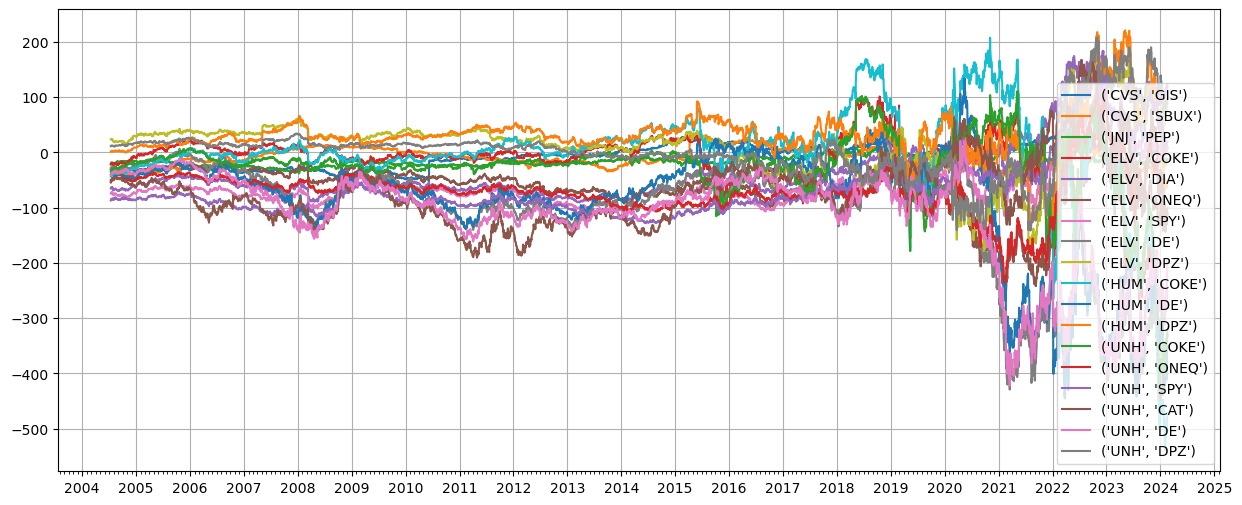

In [ ]:
spread_df = calculate_spread(all_data, johansen_pairs).dropna()
plot_dataframe(spread_df)

In [ ]:
# Hurst exponent test
for col in spread_df.columns:
    H, c, data = compute_Hc(spread_df[col], simplified=True)
    if H < 0.5:
        print(f'{col} passed: {H}')
    else:
        print(f'{col} failed: {H}')

('CVS', 'GIS') failed: 0.5034897275983182
('CVS', 'SBUX') passed: 0.4874575404050358
('JNJ', 'PEP') passed: 0.4363858116011157
('ELV', 'COKE') passed: 0.48748461261800435
('ELV', 'DIA') passed: 0.47060730479467655
('ELV', 'ONEQ') passed: 0.46111270024121004
('ELV', 'SPY') passed: 0.45463115739813403
('ELV', 'DE') passed: 0.4676675800842296
('ELV', 'DPZ') passed: 0.4890406013000042
('HUM', 'COKE') failed: 0.5047748651342413
('HUM', 'DE') passed: 0.4818104579923117
('HUM', 'DPZ') passed: 0.46245192033367194
('UNH', 'COKE') passed: 0.49699452435795216
('UNH', 'ONEQ') passed: 0.4603861637538772
('UNH', 'SPY') passed: 0.4866518756480115
('UNH', 'CAT') passed: 0.4827506206570422
('UNH', 'DE') passed: 0.4706427400576173
('UNH', 'DPZ') passed: 0.4610812950973469


In [ ]:
def calculate_half_life(spread):
    spread_lag = spread.shift(1)
    spread_diff = spread - spread_lag

    #drop NaN values
    spread_diff = spread_diff.dropna()
    spread_lag = spread_lag.dropna()

    #calculate regression coefficient theta
    theta = np.polyfit(spread_lag, spread_diff, 1)[0]

    #calculate half life
    half_life = -np.log(2) / theta

    return half_life

In [ ]:
for col in spread_df.columns:
    half_life = calculate_half_life(spread_df[col])
    if 1 < half_life < 252:
        print(f'{col} passed: {half_life}')
    else:
        print(f'{col} failed: {half_life}')

('CVS', 'GIS') failed: 508.42256784718165
('CVS', 'SBUX') passed: 236.86577684423136
('JNJ', 'PEP') passed: 116.93293398440353
('ELV', 'COKE') failed: 276.11729343929375
('ELV', 'DIA') failed: 944.1744488002283
('ELV', 'ONEQ') passed: 182.63323637108385
('ELV', 'SPY') passed: 243.87466856559843
('ELV', 'DE') failed: 324.26891236422836
('ELV', 'DPZ') passed: 165.4326255471765
('HUM', 'COKE') failed: 4132.630944262721
('HUM', 'DE') failed: 382.4392558348609
('HUM', 'DPZ') passed: 85.21737167449541
('UNH', 'COKE') passed: 214.17277202429963
('UNH', 'ONEQ') passed: 171.6810631889312
('UNH', 'SPY') failed: 542.2666187153662
('UNH', 'CAT') passed: 216.41507957675802
('UNH', 'DE') passed: 249.7575097088573
('UNH', 'DPZ') passed: 195.54004259547202


In [ ]:
def count_mean_crossings(spread, mean):

    #create binary series where 1 indicates spread is above mean and 0 indicates spread is below mean
    above_mean = spread > mean
    below_mean = spread < mean

    #calculate number of times spread crosses mean
    mean_crossings = ((above_mean.shift(1) != above_mean) & (below_mean.shift(1) != below_mean)).sum()

    return mean_crossings

In [ ]:
for col in spread_df.columns:
    mean = spread_df[col].expanding().mean()
    mean_crossings = count_mean_crossings(spread_df[col], mean)
    if mean_crossings >= 12:
        print(f'{col} passed: {mean_crossings}')
    else:
        print(f'{col} failed: {mean_crossings}')

('CVS', 'GIS') passed: 75
('CVS', 'SBUX') passed: 61
('JNJ', 'PEP') passed: 141
('ELV', 'COKE') passed: 130
('ELV', 'DIA') passed: 81
('ELV', 'ONEQ') passed: 88
('ELV', 'SPY') passed: 139
('ELV', 'DE') passed: 116
('ELV', 'DPZ') passed: 99
('HUM', 'COKE') passed: 106
('HUM', 'DE') passed: 108
('HUM', 'DPZ') passed: 160
('UNH', 'COKE') passed: 156
('UNH', 'ONEQ') passed: 120
('UNH', 'SPY') passed: 95
('UNH', 'CAT') passed: 86
('UNH', 'DE') passed: 112
('UNH', 'DPZ') passed: 59


In [ ]:
final_pairs = [('CVS', 'SBUX'), ('JNJ', 'PEP'), ('ELV', 'ONEQ'), ('ELV', 'SPY'), ('ELV', 'DPZ'), ('HUM', 'DPZ'), ('UNH', 'COKE'), ('UNH', 'ONEQ'), ('UNH', 'CAT'), ('UNH', 'DE'), ('UNH', 'DPZ')]
print(f'Number of Pairs: {len(final_pairs)}')

Number of Pairs: 11
